# PyTorch end to end workflow


**We are going to cover**

1. Data Preparation and loading (get to tensor)
2. Build model
3. Fit the model based on data (train)
4. Predict on test data
5. Check model score - visualize and evaluate model
6. Get everything together




In [1]:
# Let's import key libraries
import torch
from torch import nn  # nn has all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import Markdown as md
print(torch.__version__)

2.4.1+cu121


# 1.Data Preparation and loading (get to tensor)


#### Data can be of any format
- structured data - csv,parquet
- image
- sound
- video
- text
- DNA/medical (kind of )

#### High level steps of ML or DL workflow
- Represent any to numbers (encoding)
- Build model to decipher patter in these mumbers
- Decoding results back to input data format


To begin with let's create some kind of data using linear regression formula.
We can use known params to get datapoints for a line

---

**Linear reg equation ->**

**Y = mx + b**

m : weight, b : bias




In [2]:
# Known params for linear Reg (We need to estimate these params at the end)
weight = 0.5
bias = 0.8

In [3]:
# Create sample data
X = torch.arange(0,10, 0.1).unsqueeze(dim=1) # Adding unsqueeze to avoid shape conflict in modeling
X[:10]
y = (weight * X) + bias
assert(len(X) == len(y))

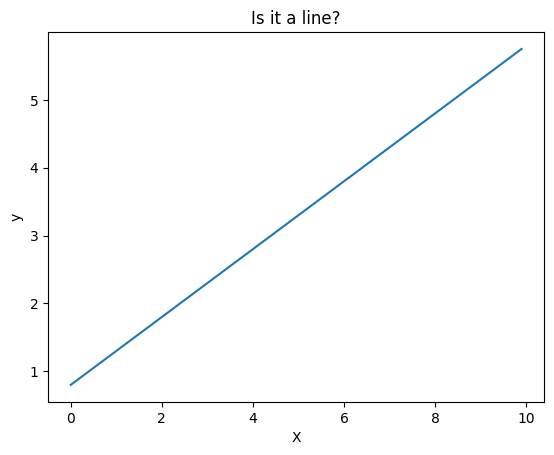

In [4]:
# To be sure we have a line with these x and y
plt.plot(X,y)
plt.title("Is it a line?")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

## Lets split data into train, validation and test sets

In [5]:
len(X)

100

In [6]:
# train:val:test = 80:10:10
train_split_index = int(len(X) * 0.8)  # We could also use shuffle / sklearn train_split_split methods
val_split_index = int(len(X) * 0.9)
test_split_index = len(X)

X_train, y_train = X[:train_split_index], y[:train_split_index]
X_val, y_val = X[train_split_index:val_split_index], y[train_split_index:val_split_index]
X_test, y_test = X[val_split_index:], y[val_split_index:]

assert(len(X_train) == len(y_train))
assert(len(X_val) == len(y_val))
assert(len(X_test) == len(y_test))

In [7]:
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(80, 80, 10, 10, 10, 10)

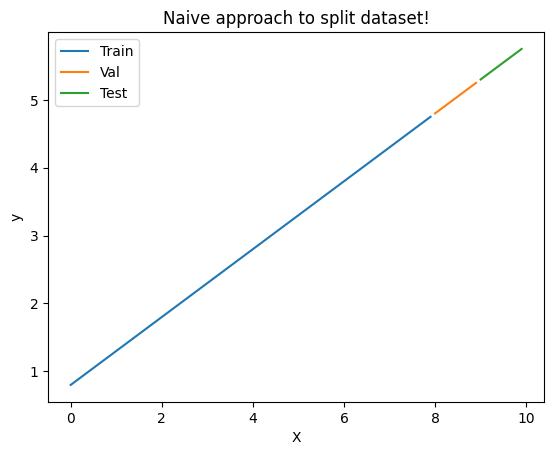

In [8]:
# Seeing how does 3 sets look like
plt.plot(X_train, y_train)
plt.plot(X_val, y_val)
plt.plot(X_test, y_test)
plt.title("Naive approach to split dataset!")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(["Train", "Val", "Test"])
plt.show()

# 2.Build model

- We are going to build the model from scratch(still high level - can use numpy  but PyTorch has simplified the process).

- Need familiarity with OOPs concepts from CS-- as we will be using class.
- Look at training data and adjust params(w & b) to learn patterns in data

- How is it done?
  - Gradient descent - https://youtu.be/IHZwWFHWa-w?si=ow3zXAoCOyIZOK01
  - Back propagation - https://youtu.be/Ilg3gGewQ5U?si=uMmuPQIvEMD_aLpv

In [9]:
# Create Linear regression model class

class Linear_regr(nn.Module): # inherits from nn.Module (base class for all NN models)
    def __init__(self):
        super().__init__()

        # init model params
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # Forward method
    def forward(self, x: torch.tensor) -> torch.tensor: # x is input data
        return self.weights * x + self.bias

## Just a few pytorch model building essentials

* torch.nn - contains all of the building blocks for neural network model building (computational graph)
* torch.nn.parameters -  what params should the model try?
* torch.nn.Module -  base class for all NN models. Make sure to overwrite forward pass MethodDescriptorType
* torch.optim - has methods to converge to best weights/ params

## Check content of our PyTorch model

let's see what's inside the model -- `parameters`

In [10]:
# create random seed
torch.manual_seed(42)

# Create a subclass of model
model_1 = Linear_regr()

# check params
list(model_1.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [11]:
# List named parameters
model_1.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making prediction using `torch.inference_mode()`

predicting on x_test and comparing against y_test

In [12]:
# Making predictions

# inference.mode can be faster for test data prediction instead of using y_preds = model_1(X_test) directly
with torch.inference_mode():  # Context manager. It disables all grad calculation for training. Use this only when predicting on test
  y_preds = model_1(X_test)

# Result isn't great
y_test, y_preds

(tensor([[5.3000],
         [5.3500],
         [5.4000],
         [5.4500],
         [5.5000],
         [5.5500],
         [5.6000],
         [5.6500],
         [5.7000],
         [5.7500]]),
 tensor([[3.1590],
         [3.1927],
         [3.2264],
         [3.2600],
         [3.2937],
         [3.3274],
         [3.3610],
         [3.3947],
         [3.4284],
         [3.4620]]))

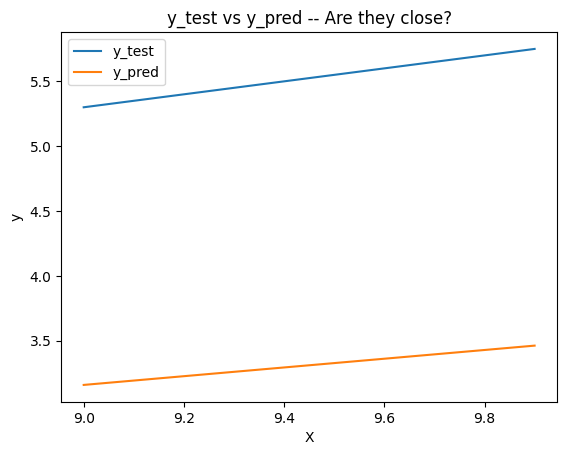

In [13]:
# Visualizing the result
plt.plot(X_test, y_test)
plt.plot(X_test, y_preds)
plt.title("y_test vs y_pred -- Are they close?")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(["y_test", "y_pred"])
plt.show()

# 3.Fit the model based on data (train)

 Train data using x_train data

- **introduce a loss function** Loss function tells how bad is the current prediction is - https://pytorch.org/docs/stable/nn.html#loss-functions
- **Introduce Optimizer** -  to move bad prediction to good predictions. Updated weights and biases - https://pytorch.org/docs/stable/optim.html

In [14]:
# List named parameters
model_1.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [15]:
# Setting up loss Using MAE
loss_fn = nn.L1Loss()
loss_fn(y_test, y_preds)

# Set up optimizer -- Using SGD (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model_1.parameters(), lr  = 0.003)  # lr =  learning rate


Steps followed - Loop through untill loss is minimal
1. Forward pass
2. Calculate loss
3. Calculate gradient and Back propagation
4. Update parameters using an Optimizer



In [16]:
# Set seed
torch.manual_seed(42)

# An epoch is one loop through training data
epochs = 800

train_loss_capture = []
val_loss_capture = []
for epoch in range(epochs):
    # set the model to training mode
    model_1.train() # Sets requires_grad = True

    # 1. forward pass
    y_pred = model_1(X_train)

    #2. Calculate loss
    loss = loss_fn(y_train, y_pred)
    train_loss_capture.append(loss.item())
    if epoch % 100 == 0:
      print(f"Training loss after {epoch} is {loss}")

    # 3. Calculate gradient and Back propagation
    optimizer.zero_grad() # to clear out the gradients of all parameters that the optimizer is tracking
    loss.backward()

    # 4. Update parameters using an Optimizer
    if epoch == 400:                          # If you really want to overfit --  in normal use case it is an overkill
      optimizer.param_groups[0]['lr'] = 0.001
    if epoch == 700:
      optimizer.param_groups[0]['lr'] = 0.0005

    optimizer.step()

    model_1.eval()

    # Testing on validation set
    with torch.inference_mode():  # Context manager. It disables all grad calculation for training. Use this only when predicting on test
      y_pred_val = model_1(X_val)
      val_loss = loss_fn(y_val, y_pred_val)
      val_loss_capture.append(val_loss.item())

print(f"Validation loss after {epochs} is {val_loss}")
print(model_1.state_dict())

Training loss after 0 is 1.3162635564804077
Training loss after 100 is 0.21248677372932434
Training loss after 200 is 0.16171850264072418
Training loss after 300 is 0.11095516383647919
Training loss after 400 is 0.06019454449415207
Training loss after 500 is 0.043270308524370193
Training loss after 600 is 0.02635008655488491
Training loss after 700 is 0.009441451169550419
Validation loss after 800 is 0.002330732299014926
OrderedDict([('weights', tensor([0.5002])), ('bias', tensor([0.7959]))])


[]

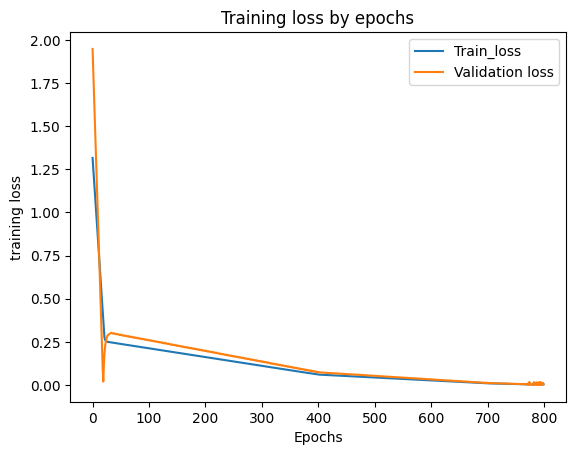

In [17]:
plt.plot(np.arange(0,epochs), train_loss_capture)
plt.plot(np.arange(0,epochs), val_loss_capture)
plt.title("Training loss by epochs")
plt.xlabel("Epochs")
plt.ylabel("training loss")
plt.legend(["Train_loss", "Validation loss"])
plt.plot()

# 4.Predict on test data

In [18]:
# Check on test data
with torch.inference_mode():  # Context manager. It disables all grad calculation for training. Use this only when predicting on test
  y_pred_test = model_1(X_test)

print(f"Test loss  is {loss_fn(y_test, y_pred_test)}")
print(model_1.state_dict())

Test loss  is 0.002123928163200617
OrderedDict([('weights', tensor([0.5002])), ('bias', tensor([0.7959]))])


# 5.Check model score - visualize and evaluate model

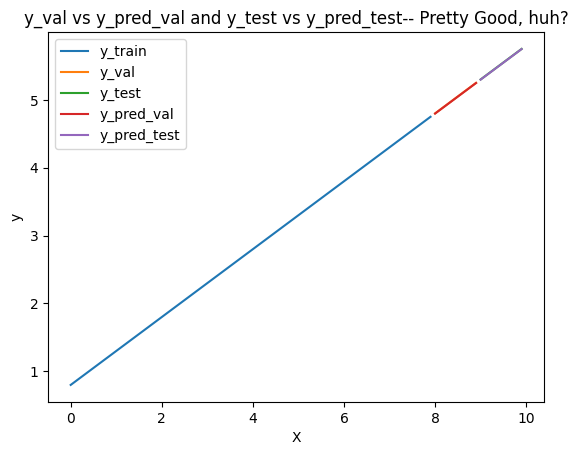

In [19]:
# Visualizing the result
plt.plot(X_train, y_train)
plt.plot(X_val, y_val)
plt.plot(X_test, y_test)
plt.plot(X_val, y_pred_val)
plt.plot(X_test, y_pred_test)
plt.title("y_val vs y_pred_val and y_test vs y_pred_test-- Pretty Good, huh?")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(["y_train", "y_val", "y_test", "y_pred_val", "y_pred_test"])
plt.show()

The above chart shows validation and test datapoints overlap with losses being extremely low. This is also shown here when we look at the parameters. They are extremely close what we had defined them


In [20]:
print(f"Predicted params: W,B: {model_1.state_dict()['weights'], model_1.state_dict()['bias']}")
print(f"Actual params: W,B {weight}, {bias}")

Predicted params: W,B: (tensor([0.5002]), tensor([0.7959]))
Actual params: W,B 0.5, 0.8


## Saving the model for a later use

* There are 3 main stes
  1. `torch.save()` - PyTorch object as a pickle file
  2. `torch.load()` - loads saved pickle files
  3. `torch.nn.Module.load_state_dict()` - loads models saved state dictionary

In [21]:
# save PyTorch model
from pathlib import Path

# 1. create Models directory
Model_path = Path("models")
Model_path.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
model_name = "linear_reg_model.pth"
model_save_path = Model_path / model_name

print(f"Saving model to: {model_save_path}")

# 3. Save model state dict
torch.save(obj=model_1.state_dict(), f=model_save_path)

Saving model to: models/linear_reg_model.pth


In [22]:
!ls -ltr models/

total 4
-rw-r--r-- 1 root root 1550 Sep 21 03:07 linear_reg_model.pth


## Load the saved model

In [23]:
loaded_model_lin_reg = Linear_regr()
loaded_model_lin_reg.load_state_dict(torch.load(model_save_path))

<ipython-input-23-4812c77c0367>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_lin_reg.load_state_dict(torch.load(model_save_path))


<All keys matched successfully>

In [24]:
loaded_model_lin_reg.state_dict()

OrderedDict([('weights', tensor([0.5002])), ('bias', tensor([0.7959]))])

In [25]:
# Make some preds
loaded_model_lin_reg.eval()
with torch.inference_mode():
  y_preds_loaded = loaded_model_lin_reg(X_test)

In [26]:
y_preds_loaded == y_pred_test

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6.Put all together with a different example --  using nn.Linear

In [27]:
# Known params for non linear curve (We need to estimate these params at the end)
weight_1 = 0.5
weight_2 = 0.7
bias = 0.8

In [28]:
# Create sample data -- Polynomial
X = torch.arange(0,10, 0.1).unsqueeze(dim=1) # Adding unsqueeze to avoid shape conflict in modeling
y = (weight_1 * (X**2)) +(weight_2 * (X**1))+  bias
assert(len(X) == len(y))

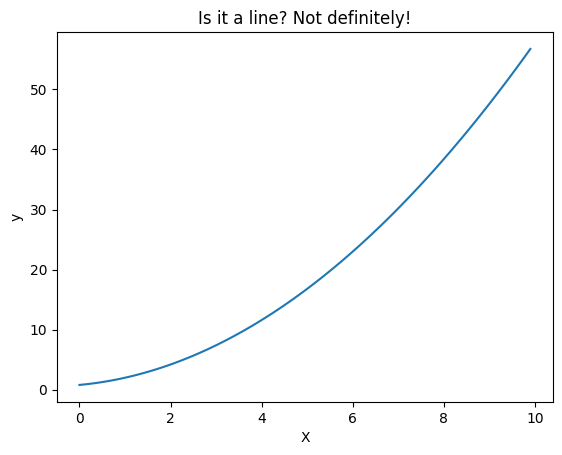

In [29]:
# To be sure we have a line with these x and y
plt.plot(X,y)
plt.title("Is it a line? Not definitely!")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

In [30]:
# train:test = 80:20 # No validation - Naive way

train_split_index = int(len(X) * 0.8)  # We could also use shuffle / sklearn train_split_split methods
test_split_index = len(X)

X_train, y_train = X[:train_split_index], y[:train_split_index]
X_test, y_test = X[train_split_index:], y[train_split_index:]

assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

In [31]:
len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

In [32]:
# Create Linear regression model class
class New_linear_model(nn.Module): # inherits from nn.Module (base class for all NN models)
    def __init__(self):
        super().__init__()

        # Use nn.Linear for creating the model param
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.tensor) -> torch.tensor: # x is input data
        return self.linear_layer(x) # There is no way we would know the exact relation bw X and Y before hand. Using this for simplicity -- to see if linear reg works!


In [33]:
# create random seed
torch.manual_seed(42)

# Create a subclass of model
model_1 = New_linear_model()

# Setting up loss Using MLE
loss_fn = nn.L1Loss(reduction='mean')
# loss_fn(y_test, y_preds)

# Set up optimizer -- Using SGD (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model_1.parameters(), lr  = 0.005)  # lr =  learning rate

# # Set seed
# torch.manual_seed(42)

# An epoch is one loop through training data
epochs = 5000

train_loss_capture = []
val_loss_capture = []
for epoch in range(epochs):
    # set the model to training mode
    model_1.train() # Sets requires_grad = True

    # 1. forward pass
    y_pred = model_1(X_train)

    #2. Calculate loss
    loss = loss_fn(y_train, y_pred)
    train_loss_capture.append(loss.item())
    if epoch % 500 == 0:
      print(f"Training loss after {epoch} is {loss}")

    # 3. Calculate gradient and Back propagation
    optimizer.zero_grad() # to clear out the gradients of all parameters that the optimizer is tracking
    loss.backward()

    # 4. Update parameters using an Optimizer
    if epoch == 500:                          # If you really want to overfit --  in normal use case it is an overkill
      optimizer.param_groups[0]['lr'] = 0.004
    if epoch == 1000:
      optimizer.param_groups[0]['lr'] = 0.003
    if epoch == 2000:
      optimizer.param_groups[0]['lr'] = 0.001

    optimizer.step()

    model_1.eval()

    # Testing on validation set
    with torch.inference_mode():  # Context manager. It disables all grad calculation for training. Use this only when predicting on test
      y_test_preds = model_1(X_test)
      val_loss = loss_fn(y_test, y_test_preds)
      val_loss_capture.append(val_loss.item())

print(f"Validation loss after {epochs} is {val_loss}")
print(model_1.state_dict())
# X_test, y_test_preds

Training loss after 0 is 10.184782981872559
Training loss after 500 is 2.9400532245635986
Training loss after 1000 is 2.7060530185699463
Training loss after 1500 is 2.5734708309173584
Training loss after 2000 is 2.4703965187072754
Training loss after 2500 is 2.4395699501037598
Training loss after 3000 is 2.413100004196167
Training loss after 3500 is 2.387392044067383
Training loss after 4000 is 2.3632075786590576
Training loss after 4500 is 2.3419528007507324
Validation loss after 5000 is 13.526575088500977
OrderedDict([('linear_layer.weight', tensor([[3.9587]])), ('linear_layer.bias', tensor([-1.6743]))])


[]

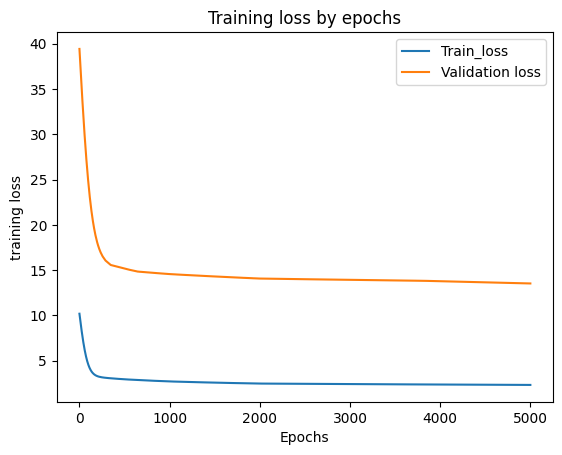

In [34]:
# Clearly see this does not work well.
# Can you see why Training and Test losses have a different starting point?
plt.plot(np.arange(0,epochs), train_loss_capture)
plt.plot(np.arange(0,epochs), val_loss_capture)
plt.title("Training loss by epochs")
plt.xlabel("Epochs")
plt.ylabel("training loss")
plt.legend(["Train_loss", "Validation loss"])
plt.plot()

In [35]:
# Best fit line parameters
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[3.9587]])),
             ('linear_layer.bias', tensor([-1.6743]))])

In [36]:
with torch.inference_mode():  # Context manager. It disables all grad calculation for training. Use this only when predicting on test
  y_full_preds = model_1(X)
  full_loss = loss_fn(y, y_full_preds)
print(f"overall loss is {full_loss}")

overall loss is 4.561872959136963


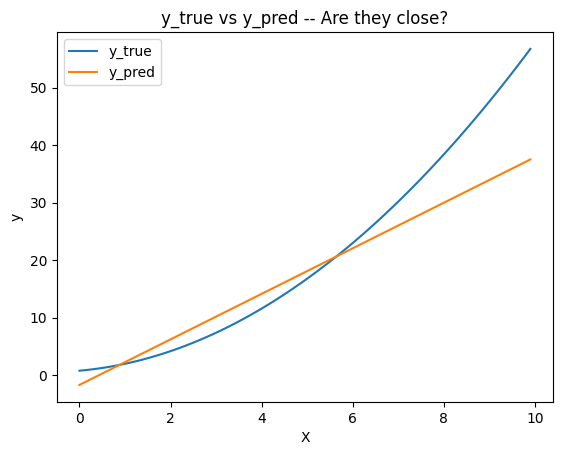

In [37]:
# Not too bad, but not great either
# Visualizing the result
plt.plot(X, y)
plt.plot(X, y_full_preds)
plt.title("y_true vs y_pred -- Are they close?")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(["y_true", "y_pred"])
plt.show()